<a href="https://colab.research.google.com/github/puc26/myProject/blob/main/20230811_WATAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

## 1.1 Background

晶圓的製作往往必須經過數百個站點(stage)的加工，製造過程中，晶圓加工的歷史資料(process record)會被自動的記錄與儲存，以作為日後進行分析追 蹤的根據，如圖一所示。而當晶圓加工完畢後，一般會對晶圓進行晶圓允收測試(wafer acceptance test，簡稱 WAT)與探針測試(circuit probe，簡稱CP)以驗證製程的穩定性與晶圓良率(yield)。

## 1.2 Data Description

提供的資料包含兩部分，每片晶圓都有代碼 ID 可以供合併:
1. 晶圓加工的歷史資料(dataX_Tool.csv)
2. 晶圓 WAT 量測結果(dataY_WAT.csv)

## 1.3 Goals and Purpose

請問該如何透過所提供的資料分析影響晶圓 WAT 穩定性的關鍵 站點與機台，並預測尚未進行測試的晶圓可能的 WAT 數值?

請跟 ChatGPT 協作，以下指引步驟逐步進行
1. 請透過探索性資料分析方法客觀的說明資料特性。
2. 依據資料特性，您會做什麼樣的資料預處理? 為什麼?
3. 依據資料特性，您會採用什麼樣的分析方法? 為什麼?
4. 請提供尚未進行測試的晶圓 WAT 預測結果。

請列出關鍵站點與機台，並說明分析流程。若有參考文獻，請一併列出。 請於時限內提供說明簡報與程式碼(附註解)。

# 2. Explorary Data Analysis (EDA)

## 2.1 Aquire Data

In [1]:
# Data wrangling libraries
import pandas as pd
import numpy as np
import random as rnd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint

# Seed used in this research
seed = 12

In [2]:
# Download the file from google drive
!gdown --id 1I77h1G73mMMlRiTGCNHM8GIv7QD9Tfjq -O data.xlsx

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I77h1G73mMMlRiTGCNHM8GIv7QD9Tfjq
To: /content/data.xlsx
100% 917k/917k [00:00<00:00, 11.1MB/s]


In [3]:
# Read the data
all_sheets = pd.read_excel('data.xlsx', sheet_name=None, engine='openpyxl')

# Peak at the data
for sheet_name, data in all_sheets.items():
    print(f"Sheet name: {sheet_name}")
    print(data.head())

Sheet name: dataX_Tool
     Wafer ID  Stage_A  Stage_B  Stage_C   Stage_D   Stage_E   Stage_F  \
0  Wafer_2367    330.0  Tool_B7  Tool_C5  Tool_D17  Tool_E11   Tool_F6   
1  Wafer_1883    340.0  Tool_B1  Tool_C3   Tool_D9  Tool_E16  Tool_F16   
2  Wafer_2476    340.0  Tool_B8  Tool_C5  Tool_D11  Tool_E10  Tool_F14   
3  Wafer_2303    330.0  Tool_B6  Tool_C3  Tool_D12  Tool_E19   Tool_F1   
4  Wafer_1341    330.0  Tool_B6  Tool_C2   Tool_D9   Tool_E4  Tool_F17   

   Stage_G  Stage_H  Stage_I  ...  Stage_T   Stage_U   Stage_V   Stage_W  \
0  Tool_G2  Tool_H4  Tool_I3  ...  Tool_T2   Tool_U6  Tool_V13   Tool_W4   
1  Tool_G4  Tool_H2  Tool_I2  ...  Tool_T2   Tool_U1   Tool_V6  Tool_W13   
2  Tool_G3  Tool_H2  Tool_I3  ...  Tool_T3   Tool_U1  Tool_V14  Tool_W15   
3  Tool_G4  Tool_H4  Tool_I3  ...  Tool_T5   Tool_U7   Tool_V7  Tool_W15   
4  Tool_G3  Tool_H2  Tool_I3  ...  Tool_T8  Tool_U10  Tool_V29   Tool_W4   

   Stage_X   Stage_Y  Stage_Z   Stage_AA   Stage_AB  Stage_AC  
0  Tool_X3 

## 2.2 Overview

In [4]:
# Infomation of the data
dataX = all_sheets['dataX_Tool']
dataY = all_sheets['dataY_WAT']

# Combined features and target
all_data = pd.merge(dataX, dataY, on='Wafer ID', how='outer')

print('Shape of dataX: ', dataX.shape[0], 'records and ', dataX.shape[1], 'attributes.')
print('Shape of dataY: ', dataY.shape[0], 'records and ', dataY.shape[1], 'attributes.')
print('Shape of all_data: ', all_data.shape[0], 'records and ', all_data.shape[1], 'attributes.')

Shape of dataX:  5442 records and  30 attributes.
Shape of dataY:  4358 records and  2 attributes.
Shape of all_data:  5442 records and  31 attributes.


The discrepancies in the record count between dataX_Tool and dataY_WAT arise from certain target values that haven't been tested yet. These untested values are reserved for subsequent forecasting.

In [5]:
# Check the first few rows of whole data
all_data.head()

,Wafer ID,Stage_A,Stage_B,Stage_C,Stage_D,Stage_E,Stage_F,Stage_G,Stage_H,Stage_I,...,Stage_U,Stage_V,Stage_W,Stage_X,Stage_Y,Stage_Z,Stage_AA,Stage_AB,Stage_AC,Mean
0,Wafer_2367,330.0,Tool_B7,Tool_C5,Tool_D17,Tool_E11,Tool_F6,Tool_G2,Tool_H4,Tool_I3,...,Tool_U6,Tool_V13,Tool_W4,Tool_X3,Tool_Y11,Tool_Z5,Tool_AA1,Tool_AB14,Tool_AC6,0.481437
1,Wafer_1883,340.0,Tool_B1,Tool_C3,Tool_D9,Tool_E16,Tool_F16,Tool_G4,Tool_H2,Tool_I2,...,Tool_U1,Tool_V6,Tool_W13,Tool_X3,Tool_Y7,Tool_Z9,Tool_AA6,Tool_AB4,Tool_AC5,0.524745
2,Wafer_2476,340.0,Tool_B8,Tool_C5,Tool_D11,Tool_E10,Tool_F14,Tool_G3,Tool_H2,Tool_I3,...,Tool_U1,Tool_V14,Tool_W15,Tool_X4,Tool_Y7,Tool_Z4,NaN,Tool_AB14,Tool_AC6,0.554639
3,Wafer_2303,330.0,Tool_B6,Tool_C3,Tool_D12,Tool_E19,Tool_F1,Tool_G4,Tool_H4,Tool_I3,...,Tool_U7,Tool_V7,Tool_W15,Tool_X5,Tool_Y6,Tool_Z7,Tool_AA14,Tool_AB17,Tool_AC5,0.546427
4,Wafer_1341,330.0,Tool_B6,Tool_C2,Tool_D9,Tool_E4,Tool_F17,Tool_G3,Tool_H2,Tool_I3,...,Tool_U10,Tool_V29,Tool_W4,Tool_X1,Tool_Y4,Tool_Z6,Tool_AA7,Tool_AB6,Tool_AC1,0.526412


In [6]:
# Check data types
all_data.dtypes

Wafer ID     object
Stage_A     float64
Stage_B      object
Stage_C      object
Stage_D      object
Stage_E      object
Stage_F      object
Stage_G      object
Stage_H      object
Stage_I      object
Stage_J      object
Stage_K      object
Stage_L      object
Stage_M      object
Stage_N      object
Stage_O      object
Stage_P      object
Stage_Q      object
Stage_R      object
Stage_S      object
Stage_T      object
Stage_U      object
Stage_V      object
Stage_W      object
Stage_X      object
Stage_Y      object
Stage_Z      object
Stage_AA     object
Stage_AB     object
Stage_AC     object
Mean        float64
dtype: object

* Two features are of float type, with one serving as the target feature.
* Out of 29 object-type features, 28 will be utilized in the test dataset, excluding the "Wafer ID" column.

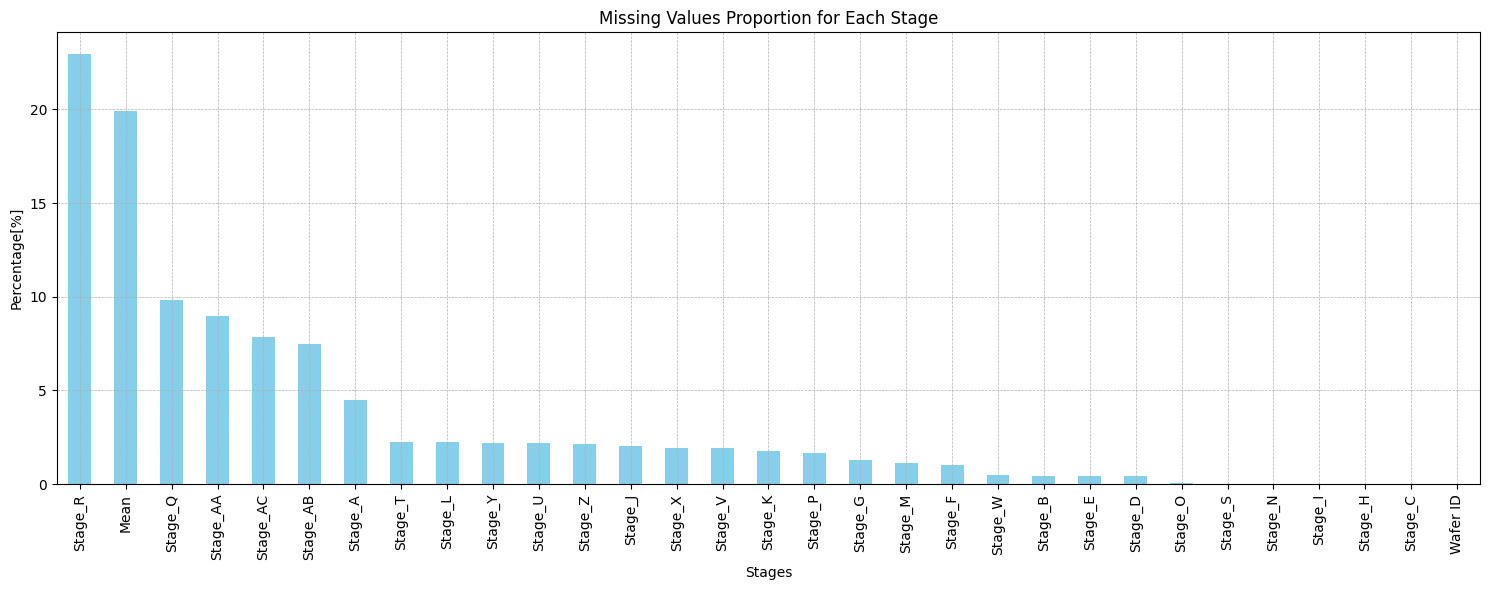

In [7]:
# Calcualte the number of missing values
missing = all_data.isnull().sum()
missing_percent = (all_data.isnull().sum() / len(all_data)) * 100

# Plot the result
plt.figure(figsize=(15, 6))
missing_percent.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Missing Values Proportion for Each Stage')
plt.ylabel('Percentage[%]')
plt.xlabel('Stages')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

* Several features exhibit missing values.
* "Stage_R" has the most significant proportion of missing values, approximately 23%, while the rest are below 10%.
* The target column, "Mean", has about 20% missing values, representing the ratio of untested chips set aside for subsequent predictions.

## 2.3 Numerical Features

In [8]:
# Distribution of numerical columns
all_data.describe()

,Stage_A,Mean
count,5197.000000,4358.000000
mean,329.069656,0.536163
std,6.131212,0.024337
min,320.000000,0.426343
25%,330.000000,0.519746
50%,330.000000,0.534756
75%,330.000000,0.551817
max,355.000000,0.630071


From the descriptive statistics, we can draw several key points:

* The standard deviation for Stage_A stands at 6.13, while for Mean, it's 0.024. This suggests that the data for Mean is more tightly clustered around its average, whereas the values for Stage_A exhibit a broader spread.
* The 25th, 50th (median), and 75th percentiles for Stage_A are all at or below 330, highlighting that a significant portion of the Stage_A data is centered around this value. On the other hand, the values for Mean appear to be more uniformly distributed throughout its range.

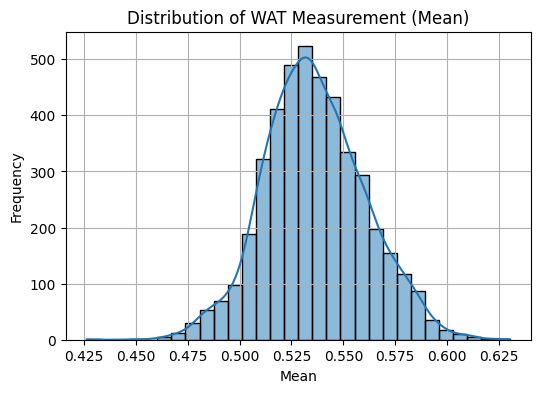

In [9]:
# Plot distribution of Mean
plt.figure(figsize=(6, 4))
sns.histplot(all_data['Mean'], kde=True, bins=30)
plt.title('Distribution of WAT Measurement (Mean)')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the histogram of the Mean, the distribution of the Mean data appears uniform and most of the measured values are concentrated in the range of 0.5 to 0.6, closely resembling a normal distribution.

In [10]:
# Calculate correlation between Stage_A and Mean
correlation = all_data[['Stage_A', 'Mean']].corr()
correlation

,Stage_A,Mean
Stage_A,1.000000,-0.120344
Mean,-0.120344,1.000000


The correlation coefficient is about -0.12, indicating a slight negative correlation between of two.

In [11]:
# Count the unique values for Stage_A
all_data['Stage_A'].value_counts()

330.0    3375
320.0    1157
340.0     564
355.0      42
335.0      34
325.0      25
Name: Stage_A, dtype: int64

From our analysis, it's evident that the Stage_A values are limited in variety, and the distribution of those values ​​is not continuous.

Notably, the most frequent category is centered around 330. This distribution suggests that Stage_A behaves more like a categorical variable rather than a continuous numerical one.

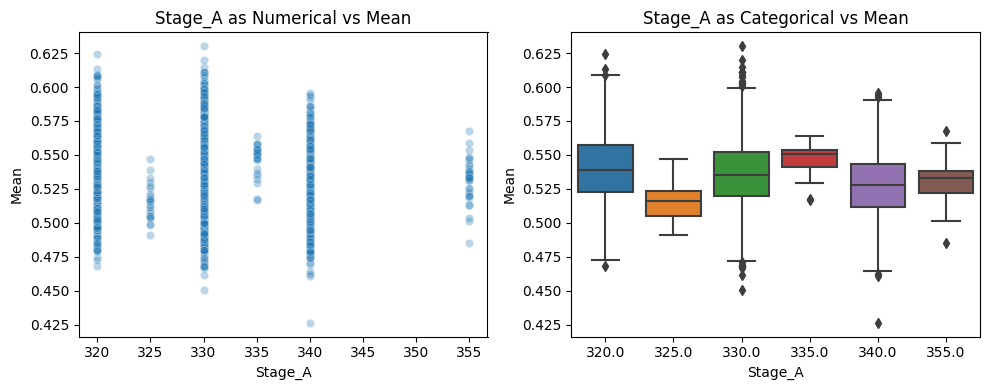

In [12]:
# Extracting non-missing Stage_A values
non_missing_stage_a = all_data[~all_data['Stage_A'].isnull()]

# Setting up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the correlation for Stage_A as numerical
sns.scatterplot(x='Stage_A', y='Mean', data=non_missing_stage_a, ax=ax[0], alpha=0.3)
ax[0].set_title('Stage_A as Numerical vs Mean')
ax[0].set_xlabel('Stage_A')
ax[0].set_ylabel('Mean')

# Plotting the distribution for Stage_A as categorical
sns.boxplot(x='Stage_A', y='Mean', data=non_missing_stage_a, ax=ax[1])
ax[1].set_title('Stage_A as Categorical vs Mean')
ax[1].set_xlabel('Stage_A')
ax[1].set_ylabel('Mean')

plt.tight_layout()
plt.show()

**As a Numerical Variable:**  
The scatter plot indicates that there isn't a distinct linear correlation between Stage_A and Mean.

**As a Categorical Variable:**  
The box plot illustrates variations in the Mean across different Stage_A values, suggesting that distinct Stage_A values do correspond to different Mean values.

In conclusion, considering Stage_A as a categorical variable might provide a clearer insight into its relationship with Mean, we will treat it as a categorical feature afterward.

In [13]:
# Change datatype of Stage_A
all_data["Stage_A"] = all_data["Stage_A"].astype('object')
all_data.dtypes

Wafer ID     object
Stage_A      object
Stage_B      object
Stage_C      object
Stage_D      object
Stage_E      object
Stage_F      object
Stage_G      object
Stage_H      object
Stage_I      object
Stage_J      object
Stage_K      object
Stage_L      object
Stage_M      object
Stage_N      object
Stage_O      object
Stage_P      object
Stage_Q      object
Stage_R      object
Stage_S      object
Stage_T      object
Stage_U      object
Stage_V      object
Stage_W      object
Stage_X      object
Stage_Y      object
Stage_Z      object
Stage_AA     object
Stage_AB     object
Stage_AC     object
Mean        float64
dtype: object

## 2.4 Categorical Features

In [14]:
categorical_cols = all_data.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('Wafer ID')

In [15]:
all_data.describe(include=['O'])

,Wafer ID,Stage_A,Stage_B,Stage_C,Stage_D,Stage_E,Stage_F,Stage_G,Stage_H,Stage_I,...,Stage_T,Stage_U,Stage_V,Stage_W,Stage_X,Stage_Y,Stage_Z,Stage_AA,Stage_AB,Stage_AC
count,5442,5197.0,5418,5442,5419,5419,5386,5373,5442,5442,...,5319,5323,5338,5417,5336,5323,5326,4954,5035,5015
unique,5442,6.0,8,5,20,27,19,4,4,15,...,9,11,30,15,5,11,11,14,19,8
top,Wafer_2367,330.0,Tool_B2,Tool_C2,Tool_D9,Tool_E21,Tool_F7,Tool_G2,Tool_H3,Tool_I14,...,Tool_T5,Tool_U1,Tool_V7,Tool_W12,Tool_X5,Tool_Y7,Tool_Z11,Tool_AA13,Tool_AB14,Tool_AC7
freq,1,3375.0,1161,1403,546,634,553,1824,2474,1192,...,1109,1012,624,1055,1635,879,770,678,399,916


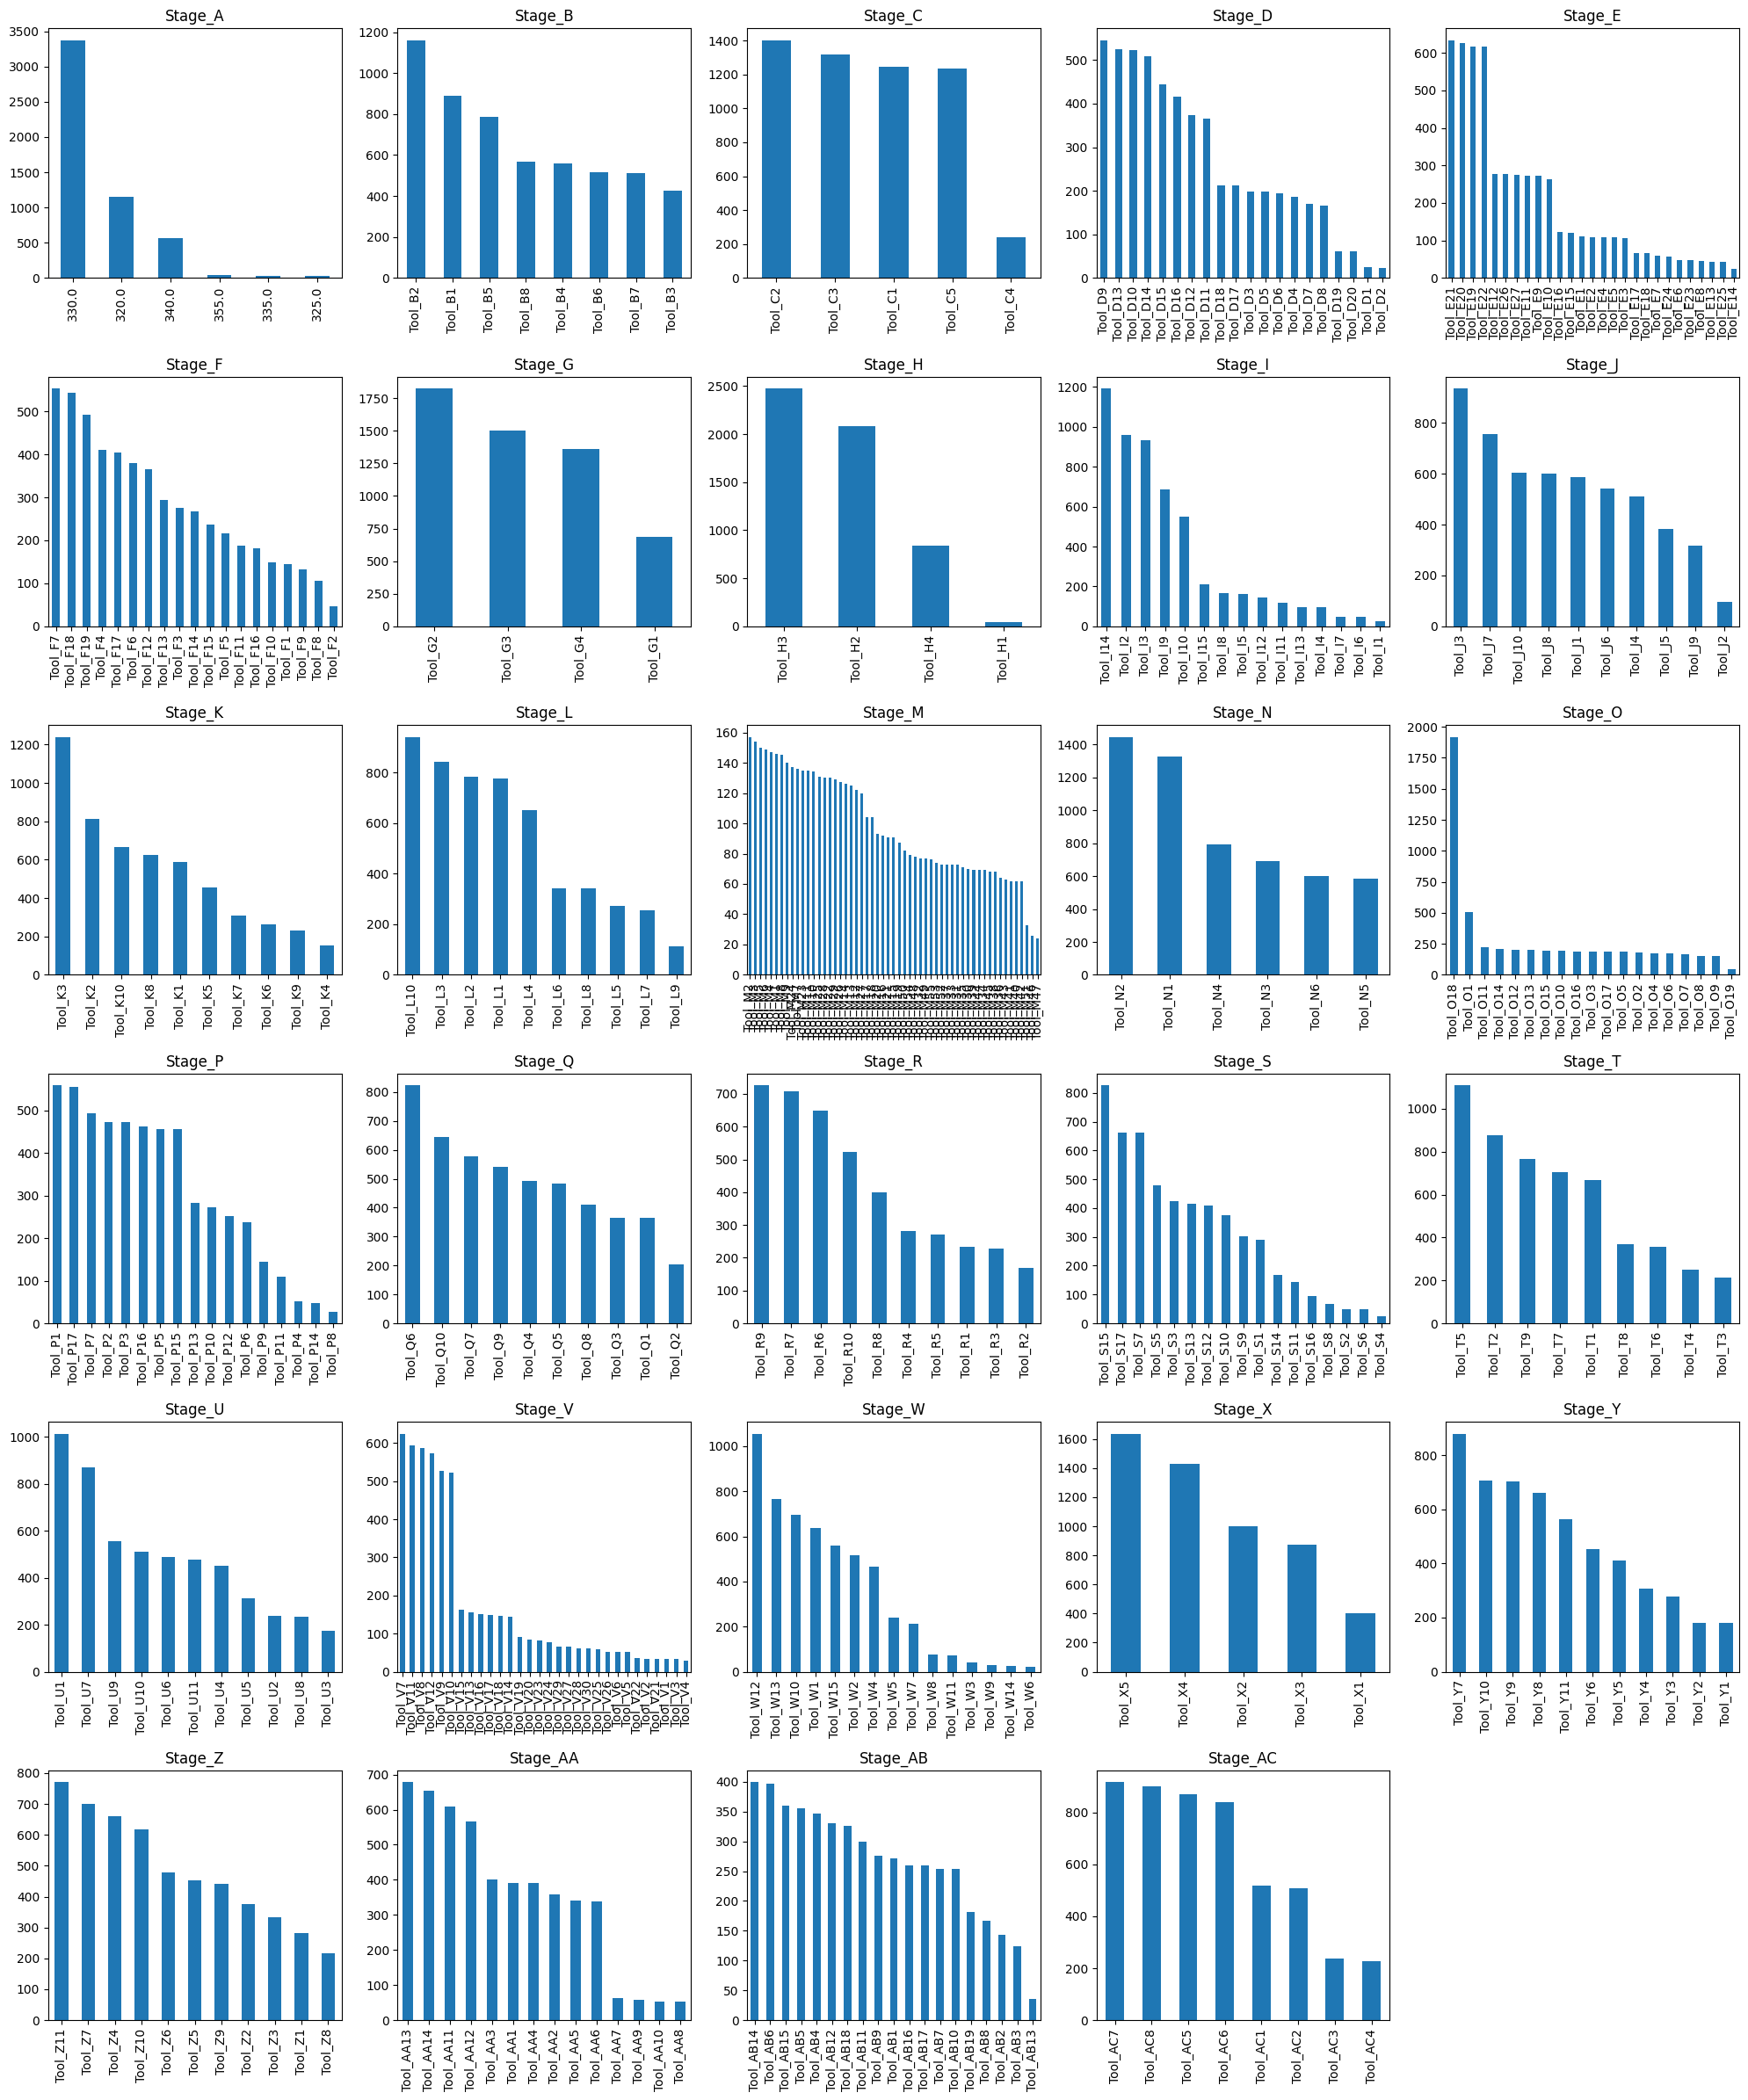

In [16]:
# Plotting the bar plots for each categorical column
num_categorical = len(categorical_cols)
rows = (num_categorical // 5) + (1 if num_categorical % 5 else 0)
plt.figure(figsize=(20, rows * 4))

for index, column in enumerate(categorical_cols, 1):
    plt.subplot(rows, 5, index)
    all_data[column].value_counts().plot(kind='bar')
    plt.title(column)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

* Categories of each feature are correctly marked.
* Each feature has multiple possible categories, and there are several main categories.
* There are several low-count categories in some features, which may be caused some noise to the model.


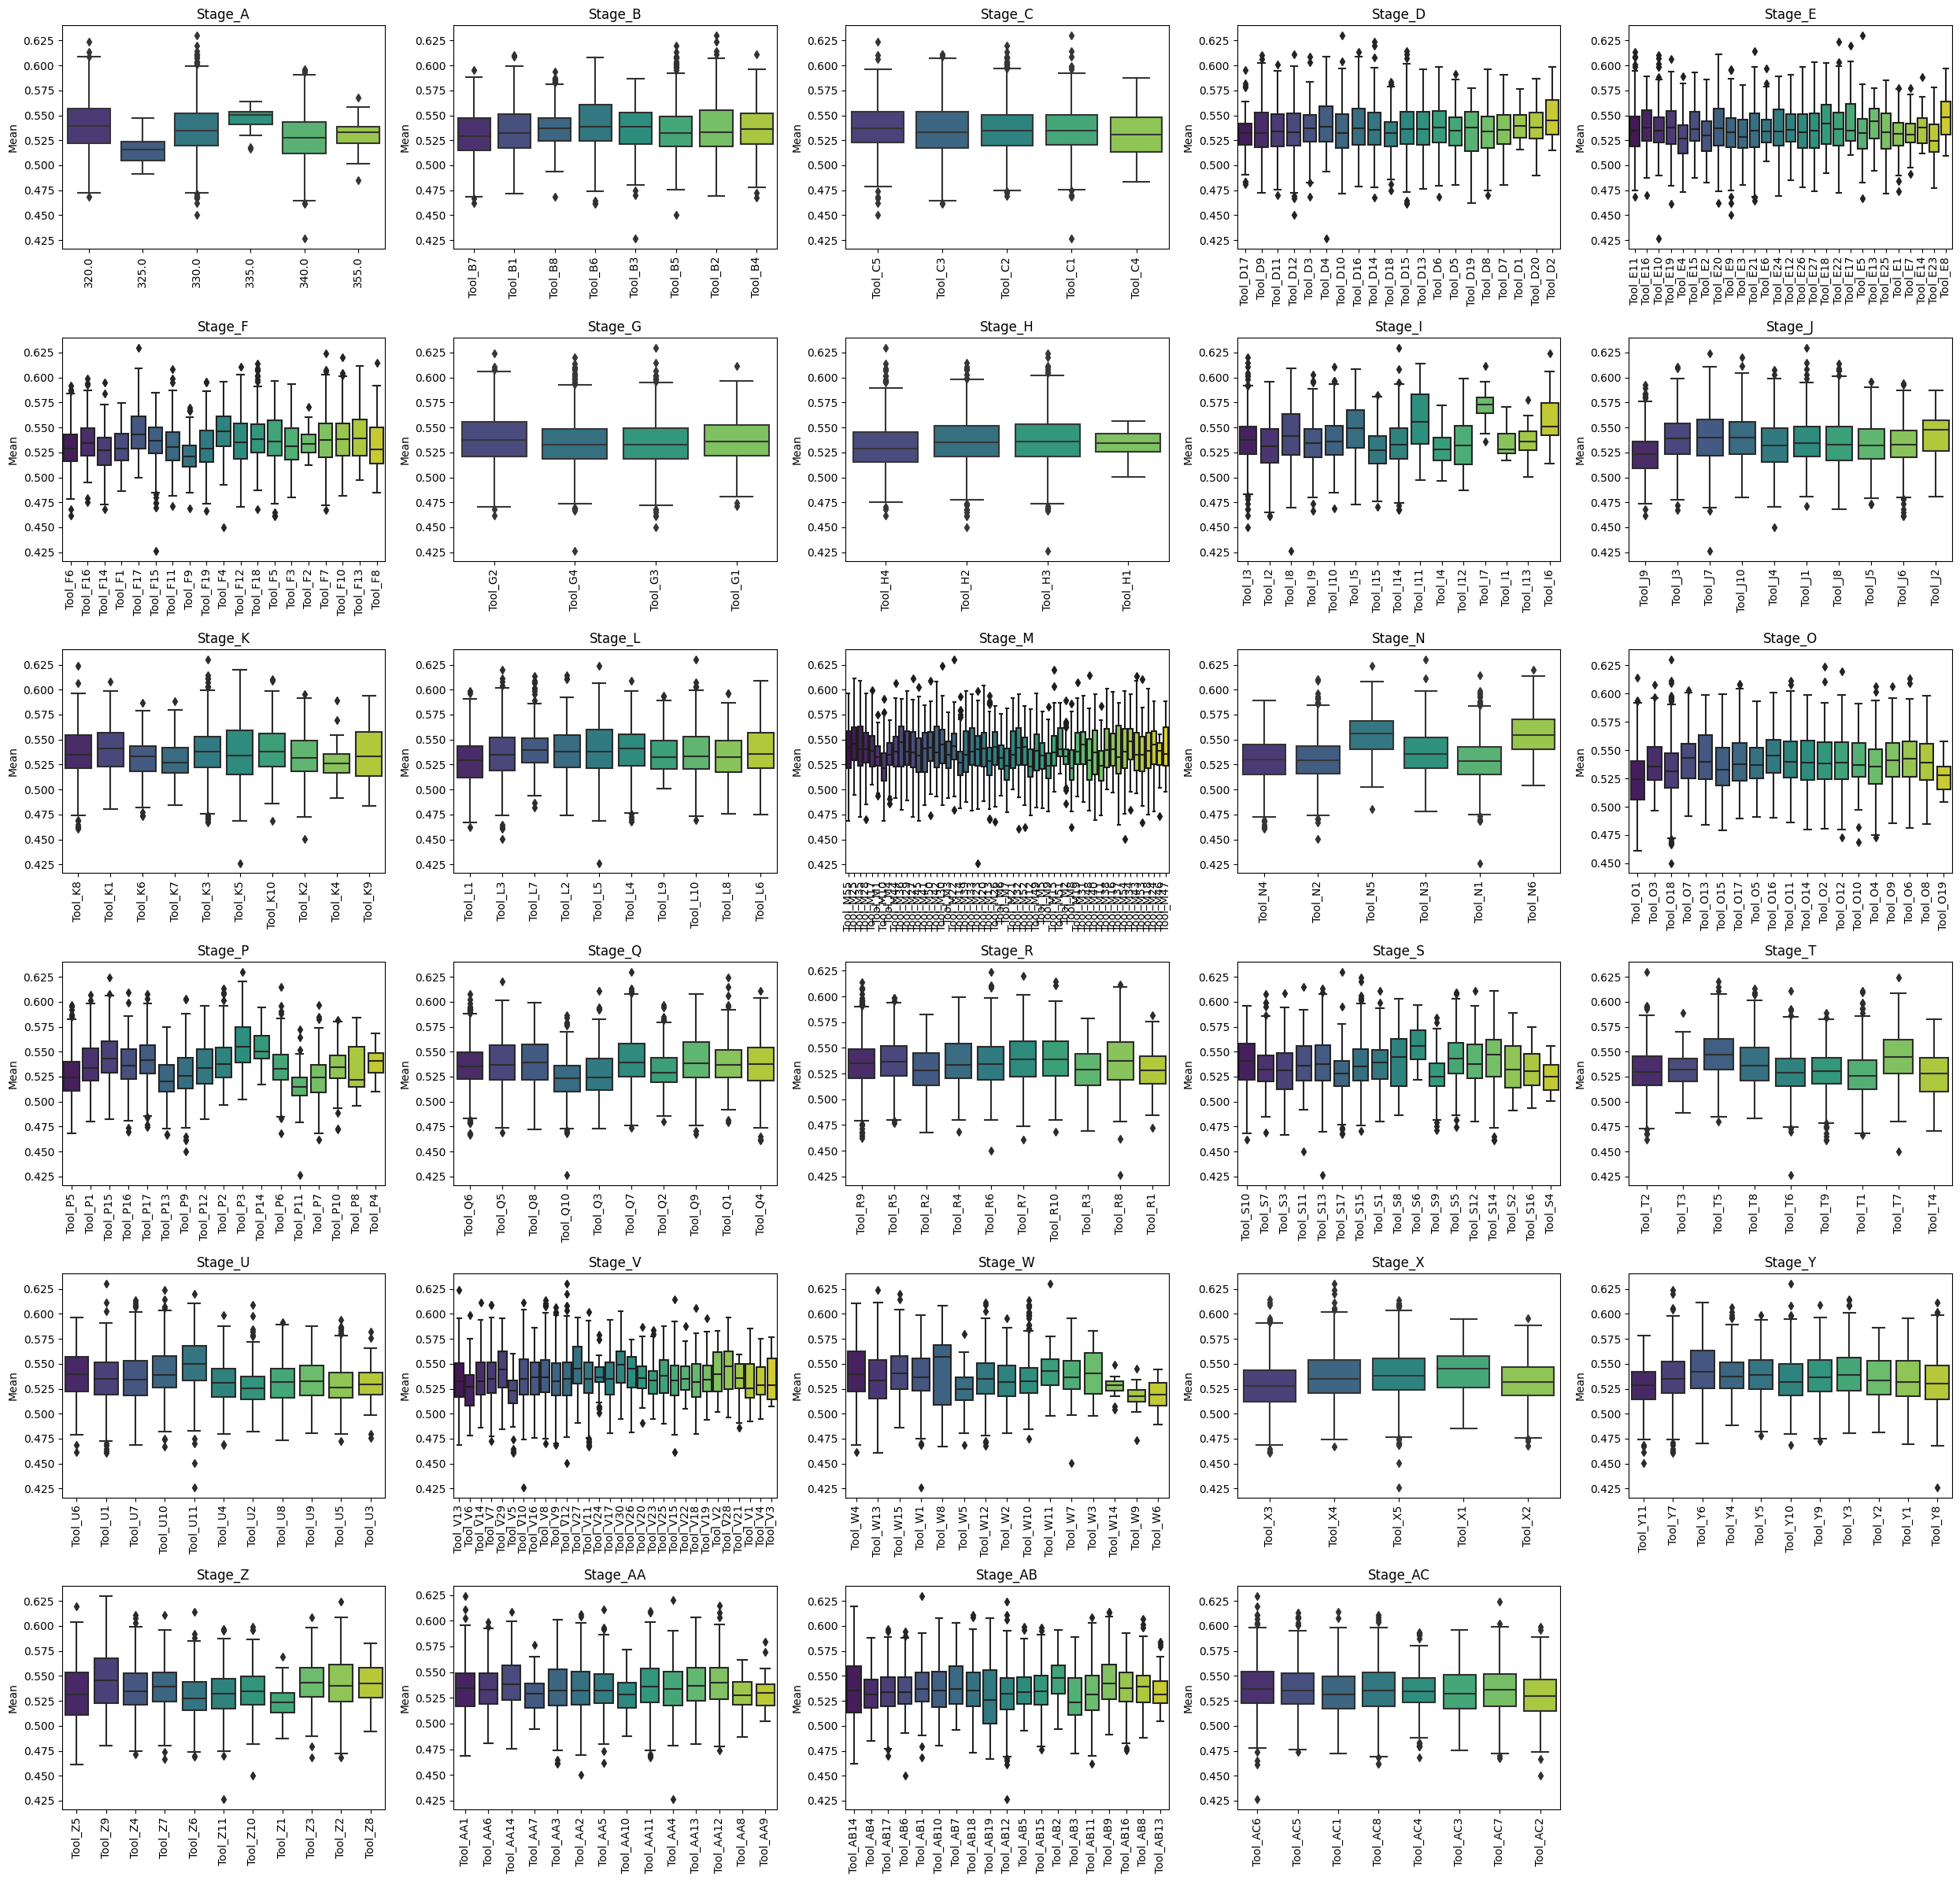

In [17]:
# Adjusting the layout for plotting
num_categorical = len(categorical_cols)
rows = (num_categorical // 5) + (1 if num_categorical % 5 else 0)

# Plotting the bar plots for each categorical column
plt.figure(figsize=(25, rows * 4))

for index, column in enumerate(categorical_cols, 1):
    plt.subplot(rows, 5, index)
    sns.boxplot(data=all_data, x=column, y='Mean', palette='viridis')
    plt.title(column)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

For all the features analyzed, we observe that the average of Mean for most categories doesn't show significant deviation from the overall average of Mean. This suggests that the categories within these features exert a comparable influence on the target variable, Mean. It also implies that no specific category predominantly affects Mean. The impact of these features on the target might be accumulative or interactive in nature.

#### Summary of Features Analysis
* The dataset comprises categorical features with multiple categories.
* Some categories within these features are dominant, while others are less frequent.
The less frequent categories might introduce noise to the model.
* No single category appears to notably influence the target variable, Mean.
* The influence on Mean seems to stem from the collective impact of these categories, either accumulatively or interactively.
* Considering the categories with low frequency potentially produce noise to the model, it will merge into one category named 'others' for each feature.

## 2.5 Missing Values

Given the nature of the dataset, where features are represented by ambiguous codenames, it's challenging to discern the precise implications of each "Stage." With respect to missing values, we can hypothesize two scenarios:  

**Missing Values Indicate Irrelevance or Data Collection Issues:**  
* The missing values might not hold any substantial meaning.
* Despite undergoing data processing, there might have been issues in the collection or storage of data for certain stages.

**Missing Values are Informative:**  
* Certain wafers might not have passed through specific processing stages, indicating the station's role was either skipped or optional.

From the result, we noticed that the missing values of Stage_R is exceed 20%, but it still has a certain correlation. Although not very high, it also shows that the target value tends to be higher when there are missing values, indicating some kind of hidden information.

Method: Fill 'unknown' and create a new binary feature.

In [18]:
# Create a binary column for missing data for each categorical columns
missing_indicators = all_data[categorical_cols].isnull().astype(int)
missing_indicators.columns = [col for col in missing_indicators.columns]

# Merge the missing indicators with the target
missing_indicators = pd.concat([missing_indicators, all_data['Mean']], axis=1)

# Calculate correlation of missing values with the target
missing_correlations = missing_indicators.corr()['Mean'].drop('Mean')

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage (%)': missing_percent,
    'Correlation': missing_correlations}).drop(['Wafer ID', 'Mean'], axis=0).sort_values(by='Correlation', ascending=False)
missing_df

,Missing Count,Percentage (%),Correlation
Stage_Q,534,9.812569,0.054657
Stage_B,24,0.441014,0.043518
Stage_R,1250,22.969497,0.015684
Stage_T,123,2.260198,0.008998
Stage_G,69,1.267916,-0.002728
Stage_Y,119,2.186696,-0.009211
Stage_X,106,1.947813,-0.014166
Stage_A,245,4.502021,-0.022393
Stage_M,60,1.102536,-0.022423
Stage_AC,427,7.846380,-0.023627


* The correlations between missing values ​​for all Stages and Mean are between -0.1 and 0.1, indicating that missing values ​​for these features are less significantly related to Mean.  

* Missing values ​​for Stage_Q, Stage_B, and Stage_R are positively correlated with Mean, but relatively weakly.  

* Of all stages, Stage_E and Stage_D display the most pronounced negative correlation with Mean.  

* Several Stages, such as Stage_C and Stage_H, yield a correlation value of NaN. This arises because these Stages lack any missing values throughout the dataset.  



#### Summary of Missing Values Analysis
The data reveals that the missing values in various Stages are only faintly correlated with Mean. While some stages like Stage_Q, Stage_B, and Stage_R have a mild positive relationship, others like Stage_E and Stage_D lean more negatively.

This analysis underscores the importance of careful handling and imputation of missing data, as it might still have nuanced implications on the target variable, Mean.

# 3. Data Preprocessing

## 3.1 Missing Values

Based on the insights derived from the analysis of missing values and the exploratory data analysis, we can hypothesize two potential reasons for the missingness: they could either be random (meaningless) or systematic (meaningful).

**For the random or meaningless missing values:**  
  Imputing with the mode (most frequent value) appears suitable, especially for features that display a dominant category distribution.

**For systematic or meaningful missing values:**  
  Binarization might offer enhanced clarity. By transforming these into binary meta-features, we could more effectively capture underlying patterns, potentially enhancing the model's robustness. However, it's crucial to strike a balance. Binarizing every feature would double the number of columns, given that all existing features are categorical. This not only increases the model's complexity and computational requirements but also makes the results more challenging to interpret.


Here are some strategies to address the issues at hand:
* A straightforward approach would be to impute missing values with a designated category of 'unknown' for meaningful missing values.
* Filled missing values with 'unknown' for largest missing values stages (Stage_R) for both situations.
* Since missing values ​​are generally less correlated with target values, we create new binary columns only for Stage_R ​​to minimize the number of features and strengthen the message of missing values.
* The overarching goal of these strategies is to retain pivotal information about the missing values while minimizing the feature set's complexity.

### Highest Missing Values Feature

In [19]:
# Fill missing values with 'unknown' to Stage_R
all_data['Stage_R'].fillna('unknown', inplace=True)
all_data['Stage_R'].value_counts()

unknown     1250
Tool_R9      726
Tool_R7      709
Tool_R6      649
Tool_R10     524
Tool_R8      399
Tool_R4      282
Tool_R5      272
Tool_R1      234
Tool_R3      229
Tool_R2      168
Name: Stage_R, dtype: int64

In [20]:
# Create binary column for Stage_R
idx_stage_r = all_data.columns.get_loc('Stage_R')
all_data.insert(idx_stage_r + 1, 'Stage_R_missing', (all_data['Stage_R'] == 'unknown').astype(int))
all_data[['Stage_R', 'Stage_R_missing']].head()

,Stage_R,Stage_R_missing
0,Tool_R9,0
1,Tool_R9,0
2,unknown,1
3,Tool_R9,0
4,Tool_R5,0


In [21]:
# Check the missing values again, notice that Stage_R already filled
all_data[categorical_cols].isnull().sum()

Stage_A     245
Stage_B      24
Stage_C       0
Stage_D      23
Stage_E      23
Stage_F      56
Stage_G      69
Stage_H       0
Stage_I       0
Stage_J     110
Stage_K      97
Stage_L     121
Stage_M      60
Stage_N       0
Stage_O       2
Stage_P      89
Stage_Q     534
Stage_R       0
Stage_S       0
Stage_T     123
Stage_U     119
Stage_V     104
Stage_W      25
Stage_X     106
Stage_Y     119
Stage_Z     116
Stage_AA    488
Stage_AB    407
Stage_AC    427
dtype: int64

### Two Strategies


Building on our earlier discussion, we will address the two distinct scenarios of missing values – those that are random (or meaningless) and those that are systematic (or meaningful).

For clarity in our subsequent steps, we'll label the random missing values as 'A' and the systematic ones as 'B'.

In [22]:
# Random missing values (Method A)
# Fill missing values in all categorical columns with the mode
all_data_A = all_data.copy()
for col in categorical_cols:
    mode_val = all_data[col].mode()[0]
    all_data_A[col].fillna(mode_val, inplace=True)

# Check the filled result
missing_values_A = all_data_A[categorical_cols].isnull().sum()
if len(missing_values_A[missing_values_A > 0]) == 0:
  print('No missing values in all_data_A.')

No missing values in all_data_A.


In [23]:
# Meaningful missing values (Method B)
# Fill missing values in all categorical columns with 'unknown'
all_data_B = all_data.copy()
for col in categorical_cols:
    all_data_B[col].fillna('unknown', inplace=True)

# Check the filled result
missing_values_B = all_data_A[categorical_cols].isnull().sum()
if len(missing_values_B[missing_values_B > 0]) == 0:
  print('No missing values in all_data_B.')

No missing values in all_data_B.


## 3.2 Outliers

For categorical features, outliers typically manifest as categories with notably low occurrences. From our prior analysis, it's clear that these infrequent categories result from the use of varied tools. To minimize the noise these sparse categories might introduce and to enhance the generalization (prevent over-fitting) of the model, we will consolidate them into a collective category labeled 'others'.

In [24]:
# Define a function to calculate the categories below the threshold and assigned them to label 'others'
def category_proportions(data, threshold):
    low_freq_categories = []

    for col in categorical_cols:
        proportions = data[col].value_counts(normalize=True)
        low_freq = proportions[proportions < threshold]
        for index, value in low_freq.items():
            low_freq_categories.append({'Feature': col, 'Category': index, 'Proportion': value})

    return pd.DataFrame(low_freq_categories).sort_values(by=['Feature', 'Proportion'])

# Applying the function
threshold = 0.01
low_freq_A = category_proportions(all_data_A, threshold)
low_freq_B = category_proportions(all_data_B, threshold)

low_freq_A, low_freq_B

(     Feature   Category  Proportion
 2    Stage_A      325.0    0.004594
 1    Stage_A      335.0    0.006248
 0    Stage_A      355.0    0.007718
 39  Stage_AA  Tool_AA10    0.009923
 40  Stage_AA   Tool_AA8    0.009923
 41  Stage_AB  Tool_AB13    0.006431
 4    Stage_D    Tool_D2    0.004226
 3    Stage_D    Tool_D1    0.004594
 10   Stage_E   Tool_E14    0.004410
 8    Stage_E   Tool_E13    0.007902
 9    Stage_E   Tool_E25    0.007902
 7    Stage_E    Tool_E8    0.008269
 6    Stage_E   Tool_E23    0.008637
 5    Stage_E    Tool_E6    0.008820
 11   Stage_F    Tool_F2    0.008637
 12   Stage_H    Tool_H1    0.008820
 15   Stage_I    Tool_I1    0.004594
 13   Stage_I    Tool_I7    0.009188
 14   Stage_I    Tool_I6    0.009188
 18   Stage_M   Tool_M47    0.004410
 17   Stage_M   Tool_M46    0.004778
 16   Stage_M   Tool_M51    0.006064
 19   Stage_O   Tool_O19    0.008637
 22   Stage_P    Tool_P8    0.004778
 21   Stage_P   Tool_P14    0.008820
 20   Stage_P    Tool_P4    0.009555
 

It can be observed that discrepancies in the results between A and B are due to different missing value imputation strategies. And we can notice that many features have multiple categories smaller than the threshold (1% used in this research).

When consolidating rare categories into "others", we intentionally excluded "unknown". Merging "unknown" with categories under "others" could blur the interpretation of this category. Notably, in certain contexts, "unknown" might have a specific correlation with the target variable. Combining it might prevent the model from capturing this relationship accurately. Hence, to retain this crucial information we will keep "unknown" as an independent category.

In [25]:
# Function to combine low frequency categories into 'others'
def combine_low_freq_categories(dataset, threshold):
    for col in categorical_cols:
        mask = (dataset[col].value_counts(normalize=True) < threshold) & (dataset[col].value_counts(normalize=True).index != 'unknown')
        low_freq_cats = mask[mask].index

        dataset[col] = dataset[col].apply(lambda x: 'others' if x in low_freq_cats else x)
    return dataset

# Applying on both datasets
all_data_A = combine_low_freq_categories(all_data_A, threshold)
all_data_B = combine_low_freq_categories(all_data_B, threshold)

In [26]:
# Check the result (Stage_B for example)
stage_d_df = pd.DataFrame({
    'Original': all_data['Stage_D'].value_counts(),
    'Method A': all_data_A['Stage_D'].value_counts(),
    'Method B': all_data_B['Stage_D'].value_counts()})

stage_d_df

,Original,Method A,Method B
Tool_D1,25.0,NaN,NaN
Tool_D10,524.0,524.0,524.0
Tool_D11,365.0,365.0,365.0
Tool_D12,374.0,374.0,374.0
Tool_D13,526.0,526.0,526.0
Tool_D14,509.0,509.0,509.0
Tool_D15,445.0,445.0,445.0
Tool_D16,417.0,417.0,417.0
Tool_D17,213.0,213.0,213.0
Tool_D18,213.0,213.0,213.0


## 3.3 Split the Data

In [27]:
# Splitting the datasets into train and predict datasets based on the presence of 'Mean'
train_A = all_data_A[all_data_A['Mean'].notna()].drop('Wafer ID', axis=1)
predict_A = all_data_A[all_data_A['Mean'].isna()].drop(['Wafer ID', 'Mean'], axis=1)

train_B = all_data_B[all_data_B['Mean'].notna()].drop('Wafer ID', axis=1)
predict_B = all_data_B[all_data_B['Mean'].isna()].drop(['Wafer ID', 'Mean'], axis=1)

train_A.shape, predict_A.shape, train_B.shape, predict_B.shape

((4358, 31), (1084, 30), (4358, 31), (1084, 30))

In [28]:
X_A = train_A.copy()
Y_A = X_A.pop('Mean')

X_B = train_B.copy()
Y_B = X_B.pop('Mean')

In [29]:
# Train-Test split
X_train_A, X_test_A, Y_train_A, Y_test_A = train_test_split(X_A, Y_A, test_size=0.2, shuffle=True, random_state=seed)
X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(X_B, Y_B, test_size=0.2, shuffle=True, random_state=seed)

## 3.4 Categorical Encoding

Frequency encoding stands out as a straightforward and common method, particularly beneficial when navigating extensive datasets or when the categorical features contain a broad of unique entries. One of its salient advantages is that it operates independently from the target value, effectively eliminating the possibility of data leakage. This approach inherently reduces the risk of overfitting. However, one should note that frequency encoding might lead to a potential loss of information that's directly tied to the target value.

In [30]:
# Build the frequency dict
def frequency_maps(data):
    freq_maps = {}
    for col in categorical_cols:
        freq_maps[col] = data[col].value_counts(normalize=True).to_dict()
    return freq_maps

freq_map_A = frequency_maps(X_train_A)
freq_map_B = frequency_maps(X_train_B)

In [31]:
# Frequency encoding
def frequency_encode(data, frequency_maps):
    encoded_data = data.copy()
    for col in categorical_cols:
        if col in frequency_maps:
            encoded_data[col] = encoded_data[col].map(frequency_maps[col])
    return encoded_data

# Applying the frequency encoding
X_train_A = frequency_encode(X_train_A, freq_map_A)
X_test_A = frequency_encode(X_test_A, freq_map_A)
predict_A = frequency_encode(predict_A, freq_map_A)

X_train_B = frequency_encode(X_train_B, freq_map_B)
X_test_B = frequency_encode(X_test_B, freq_map_B)
predict_B = frequency_encode(predict_B, freq_map_B)

In [32]:
# Check if contain NaNs
print('No. of missing values:')
print('X_train_A: ', X_train_A.isnull().sum().sum(), '\n',\
      'X_test_A: ', X_test_A.isnull().sum().sum(), '\n',\
      'predict_A: ', predict_A.isnull().sum().sum(), '\n',\
      'X_train_B: ', X_train_B.isnull().sum().sum(), '\n',\
      'X_test_B: ', X_test_B.isnull().sum().sum(), '\n',\
      'predict_B: ', predict_B.isnull().sum().sum())

No. of missing values:
X_train_A:  0 
 X_test_A:  0 
 predict_A:  0 
 X_train_B:  0 
 X_test_B:  0 
 predict_B:  0


# 4. Build the models

Since the target value is continuous, we are dealing with a regression problem. In addition, considering that the features are all categorical data, the following models can be used:

1. Linear Regression:
* After encoding, categorical features are transformed into numerical ones, making them suitable for linear regression.
* There's a potential risk of multicollinearity after frequency encoding.

2. Tree-Based Regression (e.g., Decision Tree, Random Forest):
* Non-linear models like these can capture non-linear relationships between features and the target, which can handle the nuances of the encoded features.
* Decision trees can split the data based on frequency values, which can help in identifying patterns related to the target value based on frequencies.
* Random forests combine multiple decision trees, enhancing the robustness and accuracy of the model, and capturing patterns that might be overlooked by a single decision tree.

3. Gradient Boosting Machines (e.g., XGBoost or LightGBM):
* Gradient boosting machines build decision trees iteratively, adjusting based on the errors of previous trees.
* GBMs can automatically capture non-linear relationships in features, making them highly suitable for frequency-encoded data. * There's a risk of overfitting that needs attention.

4. Support Vector Regression (SVR):
* SVR takes into account the nonlinear nature of the data, it may be able to capture patterns in frequency-encoded data well.
* The computational complexity of SVR is based on the size of the training data, so for very large datasets, the training time can become very long.


## 4.1 Train the models


Based on the aforementioned considerations, we will proceed to construct models using linear regression, random forest, XGBoost, and SVR.

In [33]:
# Linear Regression
def lr_model(X_train, X_test, Y_train, Y_test):
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    Yhat = lr.predict(X_test)
    get_evaluation_metrics(Y_test, Yhat, 'Linear Regression')

# Random Forest Regressor
def rf_model(X_train, X_test, Y_train, Y_test):
  rf = RandomForestRegressor(n_estimators=100, random_state=seed)
  rf.fit(X_train, Y_train)
  Yhat = rf.predict(X_test)
  get_evaluation_metrics(Y_test, Yhat, 'Random Forest')

# XGBoost
def xgb_model(X_train, X_test, Y_train, Y_test):
  xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=seed)
  xgb.fit(X_train, Y_train)
  Yhat = xgb.predict(X_test)
  get_evaluation_metrics(Y_test, Yhat, 'XGBoost')

# SVR
def svr_model(X_train, X_test, Y_train, Y_test):
  svr = SVR()
  svr.fit(X_train, Y_train)
  Yhat = svr.predict(X_test)
  get_evaluation_metrics(Y_test, Yhat, 'SVR')

In this research, considering we are dealing with regression problems, the following performance metrics were utilized to evaluate our models:

* **Root Mean Square Error (RMSE):**  
Definition: RMSE is the square root of the average of the squared differences between the actual and predicted values.
Interpretation: A lower RMSE indicates a more accurate prediction. Compared to MAE, RMSE places a higher penalty on larger errors, making it especially useful when dealing with potential outliers.
Given the categorical features and numerical target, this selection of metrics provides a comprehensive understanding of our model's predictive capability and its ability to grasp inherent patterns in the data.

* **Mean Absolute Error (MAE):**  
Definition: MAE quantifies the average magnitude of errors between predicted and observed values.
Interpretation: A lower MAE indicates a better model fit to the data, reflecting smaller prediction errors.

* **R-squared:**   
Definition: This metric measures the proportion of variance in the dependent variable explained by the independent variables in the model.
Interpretation: R-squared values range between 0 and 1. A value closer to 1 signifies that the model explains a higher proportion of variance in the target variable.


In [34]:
# Get Evaluation
def get_evaluation_metrics(Y_test, Yhat, model_name):
    print(model_name)
    print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, Yhat)).round(3)}")
    print(f"MAE: {mean_absolute_error(Y_test, Yhat).round(3)}")
    print(f"R^2: {r2_score(Y_test, Yhat).round(3)}")
    print('-' * 20)

# Train and Evaluate models
def model_evaluation(X_train, X_test, Y_train, Y_test):
  lr_model(X_train, X_test, Y_train, Y_test)
  rf_model(X_train, X_test, Y_train, Y_test)
  xgb_model(X_train, X_test, Y_train, Y_test)
  svr_model(X_train, X_test, Y_train, Y_test)

In [35]:
# Evaluate the data of method A
model_evaluation(X_train_A, X_test_A, Y_train_A, Y_test_A)

Linear Regression
RMSE: 0.022
MAE: 0.018
R^2: 0.127
--------------------
Random Forest
RMSE: 0.015
MAE: 0.012
R^2: 0.621
--------------------
XGBoost
RMSE: 0.015
MAE: 0.012
R^2: 0.593
--------------------
SVR
RMSE: 0.026
MAE: 0.02
R^2: -0.159
--------------------


In [36]:
# Evaluate the data of method B
model_evaluation(X_train_B, X_test_B, Y_train_B, Y_test_B)

Linear Regression
RMSE: 0.022
MAE: 0.018
R^2: 0.147
--------------------
Random Forest
RMSE: 0.015
MAE: 0.012
R^2: 0.623
--------------------
XGBoost
RMSE: 0.015
MAE: 0.012
R^2: 0.6
--------------------
SVR
RMSE: 0.026
MAE: 0.02
R^2: -0.164
--------------------


For most metrics across the models, both methods yield nearly identical results. However, there are slight variations in the R^2 values. The comparison of the two methods and models is as followed:

**Linear Regression:** Both methods produce similar error metrics. However, Method B's R^2 value is slightly higher, indicating a marginally better fit to the data.

**Random Forest & XGBoost:** Both models perform similarly across the two methods, with Method B showing a tiny edge in the R^2 value. This suggests the model's fit is nearly the same for both methods, but Method B captures a slightly higher proportion of the variance in the data.

**SVR:** The negative R^2 values for both methods indicate that the SVR model is not fitting the data well. This suggests that SVR might not be the best choice for this dataset.


Based on the results, tree-based models, specifically Random Forest and XGBoost, appear to be the most effective for both methods. While the performance metrics for Method A and Method B are almost indistinguishable, Method B offers a marginally higher R^2 value for these models. In conclusion, we will proceed with Method B, leveraging the strengths of the Random Forest and XGBoost models for subsequent tasks.

## 4.2 Extract Importance

Understanding feature importance not only allows us to delve deeper into how a model operates but also guides us in feature selection, reducing model complexity and enhancing its generalization capability. Additionally, it serves as a tool to prevent overfitting, streamline the data collection process, and offer significant business insights by revealing the key factors in a particular business problem.

1. Model-Based Feature Importance:  
These are intrinsic methods embedded within specific models such as Random Forest and XGBoost, such importances are computed during the model training process. However, they can sometimes be biased, particularly for high-cardinality categorical features.

2. Permutation Feature Importance:  
This is a model-agnostic approach, meaning it can be applied to any estimator or machine-learning model. For each feature, its values are shuffled, and the subsequent decline in the model's performance is measured. This degradation indicates the feature's significance to the model's predictive capability. While this method provides a more unbiased estimation of feature importance than model-based methods, it can be computationally expensive.  
To discern which features are most influential in predicting outcomes on new and unfamiliar data, it's pivotal to evaluate the feature importance on the test data. Using the test data provides a more genuine reflection of a feature's significance, as it showcases the model's capability to generalize beyond the data it was trained on. This approach ensures that our interpretations and subsequent decisions are aligned with the model's real-world performance on unseen data.

In [37]:
# Plot the model-based importances
def model_based_importances(importance_values, feature_names, title):
    indices = np.argsort(importance_values)[::-1]
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.bar(range(len(indices)), importance_values[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel('Relative Importance')
    plt.tight_layout()
    plt.show()

# Plot permutation importances
def plot_permutation_importance(importance_values, feature_names, title):
    sorted_idx = importance_values.argsort()[::-1]
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.bar(range(len(sorted_idx)), importance_values[sorted_idx], align='center')
    plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
    plt.ylabel("Permutation Importance")
    plt.tight_layout()
    plt.show()

def get_importances(model, X_train, X_test, Y_train, Y_test):
    # Fit the model and get model-based importances
    model.fit(X_train, Y_train)
    importance_values = model.feature_importances_
    model_based_importances(importance_values, X_train.columns, 'Model-based Feature Importances')

    # Compute permutation importances
    result = permutation_importance(model, X_test, Y_test, n_repeats=30, random_state=seed)
    plot_permutation_importance(result.importances_mean, X_test.columns, "Permutation Feature Importances")


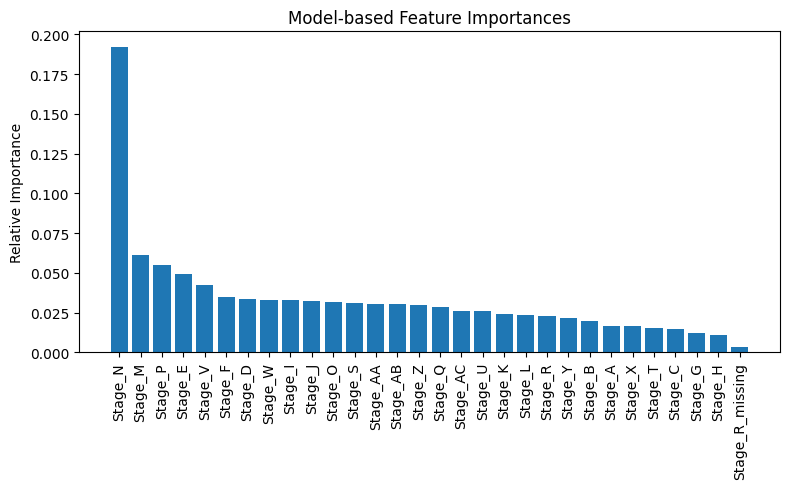

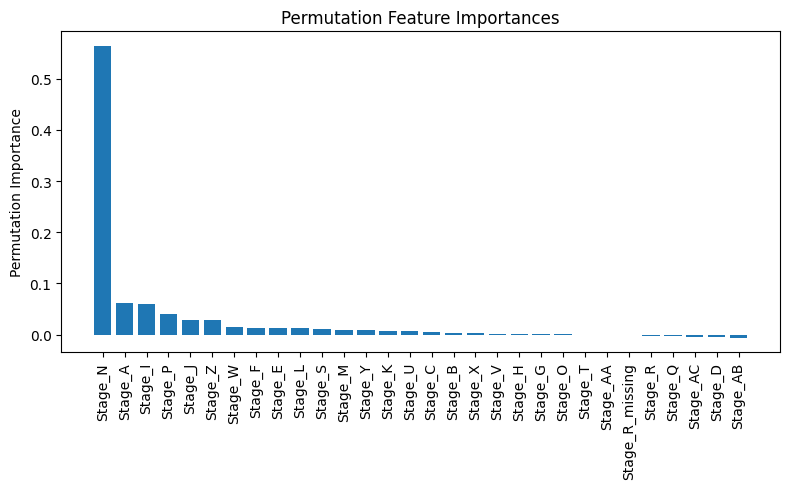

In [38]:
# Obtain the importances from random forest
rf = RandomForestRegressor(n_estimators=100, random_state=seed)
rf.fit(X_train_B, Y_train_B)
get_importances(rf, X_train_B, X_test_B, Y_train_B, Y_test_B)

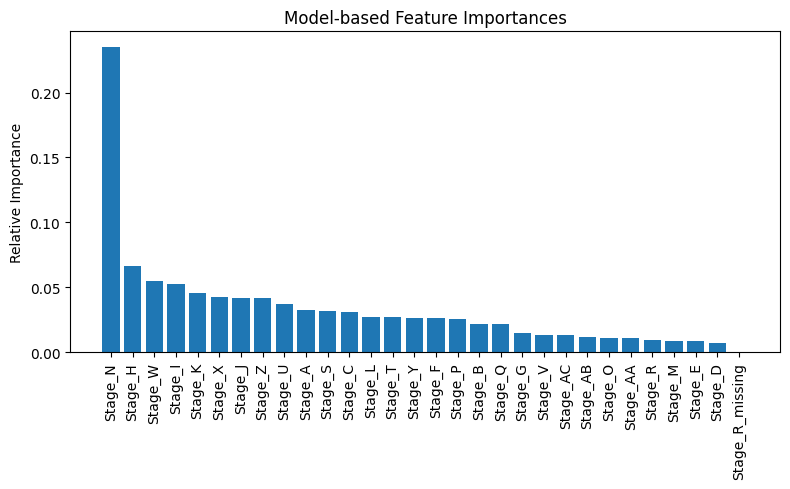

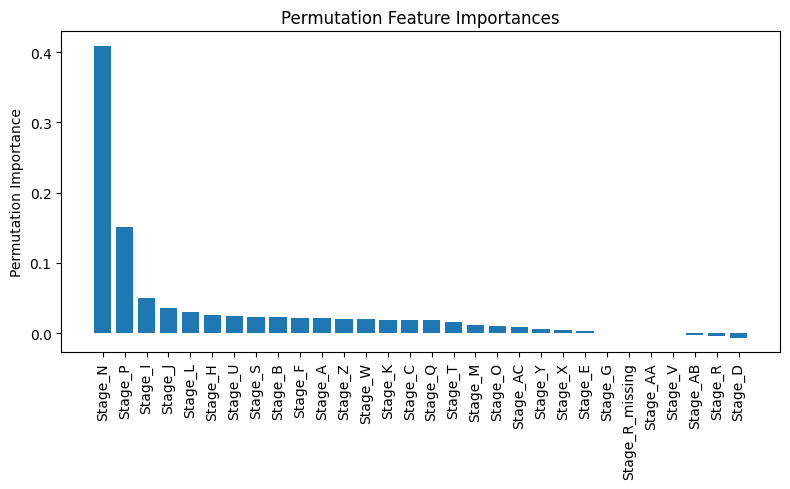

In [39]:
# Obtain the importances from random forest XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=seed)
xgb.fit(X_train_B, Y_train_B)
get_importances(xgb, X_train_B, X_test_B, Y_train_B, Y_test_B)

**Important feature**  
The results from both Model-Based and Permutation Feature Importance methods for the two models are not identical. Interestingly, features deemed less significant by the Permutation method might appear considerably important in the Model-Based assessment. Nonetheless, across both evaluation techniques and models, the feature **'Stage_N'** consistently ranks as the most influential, underscoring its pivotal role in impacting the target value. And in the more objective Permutation method, it can be found that it has a higher importance than Model-based.


**Unimportant features**  
Furthermore, the newly introduced binary feature, **'Stage_R_missing'**, doesn't seem to contribute much. It consistently ranks low or is deemed insignificant, suggesting that excluding this feature could be beneficial.

From the visualizations, we observe that some features have negative importance scores. This suggests that scrambling these features—essentially introducing noise—improves model performance. It implies that the model might be better off without them. Notably, aside from **'Stage_D'** which shows significant importance in the Model-Based random forest evaluation, its relevance is minimal or negative in other methods, leading to the consideration of its removal.

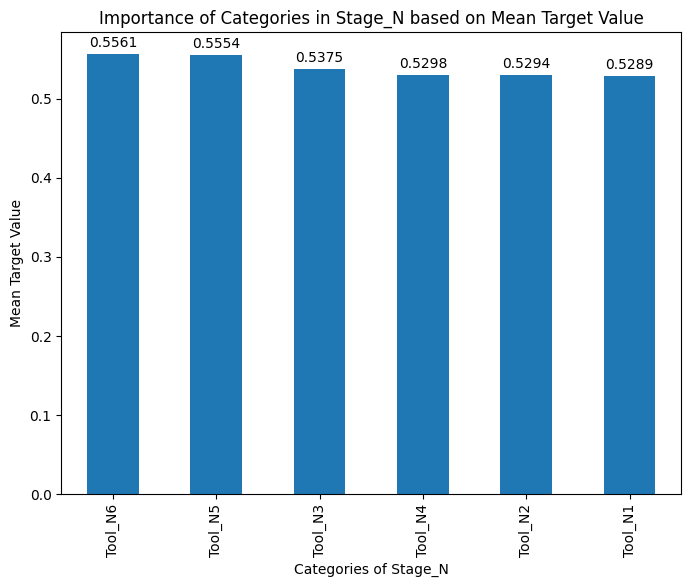

In [40]:
# Calculate the mean target value for each category in 'Stage_N'
inverse_map_B = {col: {v: k for k, v in freq_map_B[col].items()} for col in freq_map_B}

train_importances = pd.concat([X_train_B, Y_train_B], axis=1)
train_importances['Stage_N'] = train_importances['Stage_N'].map(inverse_map_B['Stage_N'])

grouped_stage_N = train_importances.groupby('Stage_N')['Mean'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
grouped_stage_N.plot(kind='bar')
plt.title("Importance of Categories in Stage_N based on Mean Target Value")
plt.ylabel("Mean Target Value")
plt.xlabel("Categories of Stage_N")

for index, value in enumerate(grouped_stage_N):
    plt.text(index, value + 0.005, f"{value:.4f}", ha='center', va='bottom')

plt.show()

Unlike One-Hot Encoding, when using frequency encoding, the importance of specific categories is not directly intuitive. So, when trying to understand the key categories of a feature under this circumstance, one can determine which categories have the most significant impact on the target by examining the average order of the categories.

From the results, it can be observed that within the Stage_N feature, the target values are somewhat uniform. However, **Tool_N6** and **Tool_N5** stand out slightly above the other categories, with a minimal difference between their values. This suggests that these two tools are the more critical categories.

## 4.3 Re-train the Model

In [41]:
#  Update the preprocessing condition - Drop the binary column and Stage_D
X_train_re = X_train_B.copy().drop(['Stage_R_missing', 'Stage_D'], axis=1)
X_test_re = X_test_B.copy().drop(['Stage_R_missing', 'Stage_D'], axis=1)
predict_re = predict_B.copy().drop(['Stage_R_missing', 'Stage_D'], axis=1)
Y_train_re = Y_train_B.copy()
Y_test_re = Y_test_B.copy()

In [42]:
print('Shape of X_train_re: ', X_train_re.shape,\
      '\nShape of Y_train_re: ', Y_train_re.shape,\
      '\nShape of X_test_re: ', X_test_re.shape,\
      '\nShape of Y_test_re: ', Y_test_re.shape,\
      '\nShape of predict_re: ', predict_re.shape)

Shape of X_train_re:  (3486, 28) 
Shape of Y_train_re:  (3486,) 
Shape of X_test_re:  (872, 28) 
Shape of Y_test_re:  (872,) 
Shape of predict_re:  (1084, 28)


In [185]:
%%capture
# Define hyper parameters
parameters = {
     'max_depth': [2*n for n in range(1,10)],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [100, 200, 500]}

# Create RandomizedSearchCV for RandomForestRegressor
rf = RandomForestRegressor(random_state=seed)
rf_cv = RandomizedSearchCV(rf, param_distributions=parameters,
                             n_iter=100, cv=5, n_jobs=-1, random_state=seed)

rf_cv.fit(X_train_re, Y_train_re)
rf_best_params = rf_cv.best_params_
print('Tuned hyperparameters: ', rf_best_params)
print('Best R^2: ', rf_cv.best_score_)

# Applying the best parameters
Yhat = rf_cv.predict(X_test_re)
get_evaluation_metrics(Y_test_re, Yhat, rf_cv)

In [186]:
# Define hyper parameters
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 20),
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0]
}

# Create RandomizedSearchCV for XGBoost
xgb = XGBRegressor(random_state=seed)
xgb_cv = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=100, cv=5,
                              verbose=1, n_jobs=-1, random_state=seed)


xgb_cv.fit(X_train_re, Y_train_re)
xgb_best_params = xgb_cv.best_params_
print('Tuned hyperparameters: ', xgb_best_params)
print('Best R^2: ', xgb_cv.best_score_)

# Applying the best parameters
Yhat = xgb_cv.predict(X_test_re)
get_evaluation_metrics(Y_test_re, Yhat, xgb_cv)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuned hyperparameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 18, 'n_estimators': 267}
Best R^2:  0.6723867083206285
RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
             

# 5. Prediction Output